# pH-rate Profile for Esters

In wqater esters have three possible routes to hydrolysis. 

1. Water attacks the carbonyl group of the ester.
2. Acid catalysis: Water attacks the protonated carbonyl group of the ester.
3. Base catalysis: Hydroxide attacks the carbonyl group of the ester

Let us explore analyzing data for ester hydrolysios

This workbook contains the code and imports the data from multiple files and fits the data to the model..

The data being plotted is from "The Hydrolysis of Diclofenac Esters: Synthetic Prodrug Building Blocks for Biodegradable Drug–Polymer Conjugates." Feng Wang, Joshua Finnin et al., *J. Pharm. Sci.*, **2016**, *105*, 773-785.  https://doi.org/10.1002/jps.24665

The data is found in tables within the supplementary material at https://ars.els-cdn.com/content/image/1-s2.0-S0022354915001550-mmc1.docx


## Setup Tools and Read Data Table

Here the data table is read in and processed. Also the libraries are imported and any functions defined

In [1]:
### SETUP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.optimize import curve_fit

import uncertainties as un
from uncertainties import unumpy as unp

import lmfit

github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_19/data/"
github_location = "data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"



## Read Data

Read the data in from the csv text file.

In [2]:
### READ DATA

data_file = "3c.csv"

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 

display(df)

,pH,k1 (10-5 hr-1),t1/2 (hr),r^2
0,1.00,2590,26.800,0.9983
1,1.90,286,243.000,0.9949
2,3.10,129,538.000,0.9940
3,4.04,136,512.000,0.9843
4,4.98,198,349.000,0.9992
5,6.09,1530,45.400,0.9937
6,6.97,12070,5.740,0.9972
7,7.42,21460,3.230,0.9996
8,7.96,91270,0.759,0.9962


[2.04429690e-01 1.10699203e-03 1.02489432e+06]
0.204+/-0.034 0.00111+/-0.00016 (1.02+/-0.10)e+06


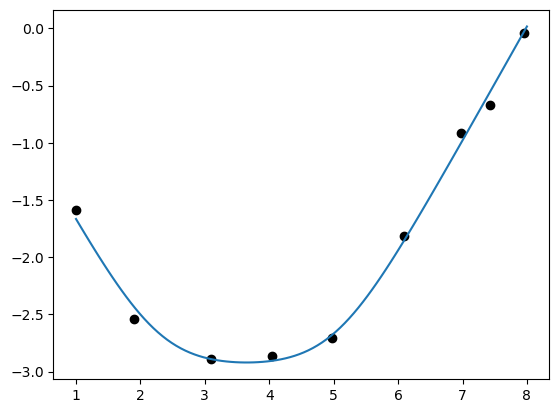

In [48]:
from scipy.optimize import curve_fit

x = df["pH"]
y = np.log10(df["k1 (10-5 hr-1)"] *1E-5)

plt.plot(x,y, "ko")

def line1(x, int):
    ### slope set to -1. We are fitting only for the intercept.
    y = x * -1 + int
    return y

def line2(x, int):
    ### slope set to +1. We are fitting only for the intercept.
    y = x * 1 + int
    return y

def model(pH, kHKa, kOH):
    H = 10**(-pH)
    Kw = 10**-13.995
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2
    return np.log10(kobs)
     
def model(pH, kHKa, kH2O, kOH):
    H = 10**(-pH)
    Kw = 10**-13.995
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2 + kH2O
    return np.log10(kobs)

popt,pcov = curve_fit(model,x,y,
                      p0 = (1,1,100),
                      bounds=([0,0,0],[np.inf,np.inf,np.inf])
                      )

kHKa, kH2O, kOH = un.correlated_values(popt,pcov)
print(kHKa, kH2O, kOH)


x1 = np.linspace(1,8,100)
y1 = model(x1, *popt)

plt.plot(x1, y1)


In [8]:
### Use curve_fit function  

# define the function for the model
def profile(pH, kHKa, kH2O, kOH):
    H = 10**(-pH)
    Kw = 10**-13.995
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2 + kH2O
    return np.log10(kobs)

# Create a model by loading the function via the lmfit.Model tool
mod = lmfit.Model(profile)  

# Set parameters - here i also set minimims so that no negative values are encountered in the fit
pars = mod.make_params(kHKa = dict(value = 1, min=0), 
                       kH2O = dict(value = 1, min=0), 
                       kOH =  dict(value = 1, min=0),
                      )

x = df["pH"]
y = np.log10(df["k1 (10-5 hr-1)"] *1E-5)


# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, pH=x)   
result